In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #import Cllback function

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir("../dataset")

In [3]:
parent = "2_0_ready"
# parent = "2_1_swt-2"
# parent = "2_2_y_cb_cr"
# parent = "2_3_y_cb_cr_prep"

train_path = f"{parent}/train"
validation_path = f"{parent}/validation"
test_path = f"{parent}/test"

In [4]:
batch_size = 32
img_height = 400
img_width = 400

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(
                rescale=1./255,
                # zoom_range=0.15, 
                # width_shift_range=0.2,
                # shear_range=0.15
                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#setting train test split
train = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        subset='training' )

test = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

validation = test_datagen.flow_from_directory(
        validation_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

Found 7620 images belonging to 2 classes.
Found 951 images belonging to 2 classes.
Found 951 images belonging to 2 classes.


In [7]:
classes = train.num_classes
classes

2

In [8]:
conv_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# conv_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# conv_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 
# conv_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 
# conv_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) 

In [9]:
conv_model.trainable = False

In [10]:
def main_model(tl_model,classess):
    m_model=tl_model.output
    m_model=Flatten()(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(512,activation='relu')(m_model)
    m_model=Dropout(.2)(m_model)
    m_model=Dense(classess,activation='softmax')(m_model)
    return m_model



In [11]:
combining_model=main_model(conv_model, classes)

In [12]:
model=Model(inputs=conv_model.input, outputs=combining_model)

In [13]:
optimizer = Adam(learning_rate=1e-4)
# optimizer = SGD(learning_rate=1e-4, momentum=.9)
# optimizer = RMSprop(learning_rate=1e-4, momentum=.9)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 406, 406, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 200, 200, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 conv2_block3_concat (Concatena  (None, 100, 100, 16  0          ['conv2_block2_concat[0][0]',    
 te)                            0)                                'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, 100, 100, 16  640        ['conv2_block3_concat[0][0]']    
 ization)                       0)                                                                
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, 100, 100, 16  0          ['conv2_block4_0_bn[0][0]']      
 n)                             0)                                                                
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 100, 100, 12  20480       ['conv2_block4_0_relu[0][0]']    
          

 conv3_block1_1_conv (Conv2D)   (None, 50, 50, 128)  16384       ['conv3_block1_0_relu[0][0]']    
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 50, 50, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 50, 50, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 50, 50, 32)   36864       ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 50, 50, 32)   36864       ['conv3_block5_1_relu[0][0]']    
                                                                                                  
 conv3_block5_concat (Concatena  (None, 50, 50, 288)  0          ['conv3_block4_concat[0][0]',    
 te)                                                              'conv3_block5_2_conv[0][0]']    
                                                                                                  
 conv3_block6_0_bn (BatchNormal  (None, 50, 50, 288)  1152       ['conv3_block5_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_0_relu (Activatio  (None, 50, 50, 288)  0          ['conv3_block6_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block10_0_relu (Activati  (None, 50, 50, 416)  0          ['conv3_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block10_1_conv (Conv2D)  (None, 50, 50, 128)  53248       ['conv3_block10_0_relu[0][0]']   
                                                                                                  
 conv3_block10_1_bn (BatchNorma  (None, 50, 50, 128)  512        ['conv3_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block2_0_bn (BatchNormal  (None, 25, 25, 288)  1152       ['conv4_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_0_relu (Activatio  (None, 25, 25, 288)  0          ['conv4_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 25, 25, 128)  36864       ['conv4_block2_0_relu[0][0]']    
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 25, 25, 32)   36864       ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_concat (Concatena  (None, 25, 25, 448)  0          ['conv4_block5_concat[0][0]',    
 te)      

 conv4_block10_2_conv (Conv2D)  (None, 25, 25, 32)   36864       ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_concat (Concaten  (None, 25, 25, 576)  0          ['conv4_block9_concat[0][0]',    
 ate)                                                             'conv4_block10_2_conv[0][0]']   
                                                                                                  
 conv4_block11_0_bn (BatchNorma  (None, 25, 25, 576)  2304       ['conv4_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_0_relu (Activati  (None, 25, 25, 576)  0          ['conv4_block11_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block15_0_relu (Activati  (None, 25, 25, 704)  0          ['conv4_block15_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, 25, 25, 128)  90112       ['conv4_block15_0_relu[0][0]']   
                                                                                                  
 conv4_block15_1_bn (BatchNorma  (None, 25, 25, 128)  512        ['conv4_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 25, 25, 128)  0          ['conv4_block15_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 25, 25, 128)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 25, 25, 32)   36864       ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_concat (Concaten  (None, 25, 25, 864)  0          ['conv4_block18_concat[0][0]',   
 ate)                                                             'conv4_block19_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block23_concat (Concaten  (None, 25, 25, 992)  0          ['conv4_block22_concat[0][0]',   
 ate)                                                             'conv4_block23_2_conv[0][0]']   
                                                                                                  
 conv4_block24_0_bn (BatchNorma  (None, 25, 25, 992)  3968       ['conv4_block23_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block24_0_relu (Activati  (None, 25, 25, 992)  0          ['conv4_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 25, 25, 128)  126976      ['conv4_block24_0_relu[0][0]']   
          

                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 12, 12, 608)  0          ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 12, 12, 608)  2432       ['conv5_block3_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block4_0_relu (Activatio  (None, 12, 12, 608)  0          ['conv5_block4_0_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 12, 12, 736)  0          ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 12, 12, 128)  94208       ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_block8_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv5_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block12_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 12, 12, 128)  0          ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 12, 12, 32)   36864       ['conv5_block12_1_relu[0][0]']   
                                                                                                  
 conv5_block12_concat (Concaten  (None, 12, 12, 896)  0          ['conv5_block11_concat[0][0]',   
 ate)                                                             'conv5_block12_2_conv[0][0]']   
          

                                                                                                  
 conv5_block16_concat (Concaten  (None, 12, 12, 1024  0          ['conv5_block15_concat[0][0]',   
 ate)                           )                                 'conv5_block16_2_conv[0][0]']   
                                                                                                  
 bn (BatchNormalization)        (None, 12, 12, 1024  4096        ['conv5_block16_concat[0][0]']   
                                )                                                                 
                                                                                                  
 relu (Activation)              (None, 12, 12, 1024  0           ['bn[0][0]']                     
                                )                                                                 
                                                                                                  
 flatten (

In [14]:
model_checkpoint = ModelCheckpoint(f"../program/model_project.h5", save_weights_only=True, save_best_only=True, monitor="val_accuracy")
learning_rate_reduce = ReduceLROnPlateau(monitor='val_accuracy',min_lr=1e-8, mode="max", patience=10, min_delta=.01)#Change learning rate if not performing good enough
early_stopping = EarlyStopping(monitor="val_accuracy", patience=15, min_delta=.01, mode="max", start_from_epoch=10)
callbacks=[learning_rate_reduce, model_checkpoint, early_stopping]

In [15]:
history=model.fit(train, validation_data=validation, epochs=50, callbacks=callbacks)

Epoch 1/50
239/239 [==============================] - 340s 1s/step - loss: 1.2204 - accuracy: 0.5797 - val_loss: 0.6709 - val_accuracy: 0.6814 - lr: 1.0000e-04
Epoch 2/50
239/239 [==============================] - 101s 420ms/step - loss: 0.5899 - accuracy: 0.7047 - val_loss: 0.4064 - val_accuracy: 0.7928 - lr: 1.0000e-04
Epoch 3/50
239/239 [==============================] - 101s 420ms/step - loss: 0.4310 - accuracy: 0.7726 - val_loss: 0.3430 - val_accuracy: 0.8034 - lr: 1.0000e-04
Epoch 4/50
239/239 [==============================] - 104s 434ms/step - loss: 0.3404 - accuracy: 0.8167 - val_loss: 0.2608 - val_accuracy: 0.8433 - lr: 1.0000e-04
Epoch 5/50
239/239 [==============================] - 102s 425ms/step - loss: 0.2738 - accuracy: 0.8588 - val_loss: 0.2097 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 6/50
239/239 [==============================] - 97s 404ms/step - loss: 0.2266 - accuracy: 0.8769 - val_loss: 0.1897 - val_accuracy: 0.8812 - lr: 1.0000e-04
Epoch 7/50
239/239 [======

In [16]:
os.chdir("../program/")
model.load_weights('model_project.h5')  # load best val_accuracy
os.chdir("../dataset/")

In [17]:
test_score=model.evaluate(test)

30/30 [==============================] - 31s 1s/step - loss: 0.1237 - accuracy: 0.9359


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import itertools

target_names=[]
for key in train.class_indices:
    target_names.append(key)

In [19]:
def plot_cfx(cm, classess, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks=np.arange(len(classess))
    plt.xticks(tick_marks, classess, rotation=45)
    plt.yticks(tick_marks, classess)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print('Confusion Matrix dengan Normalisasi')
    else:
        print('Confusion Matrix dengan Tanpa Normalisasi')
    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
        

30/30 [==============================] - 12s 343ms/step
confusion Matrix
Confusion Matrix dengan Tanpa Normalisasi


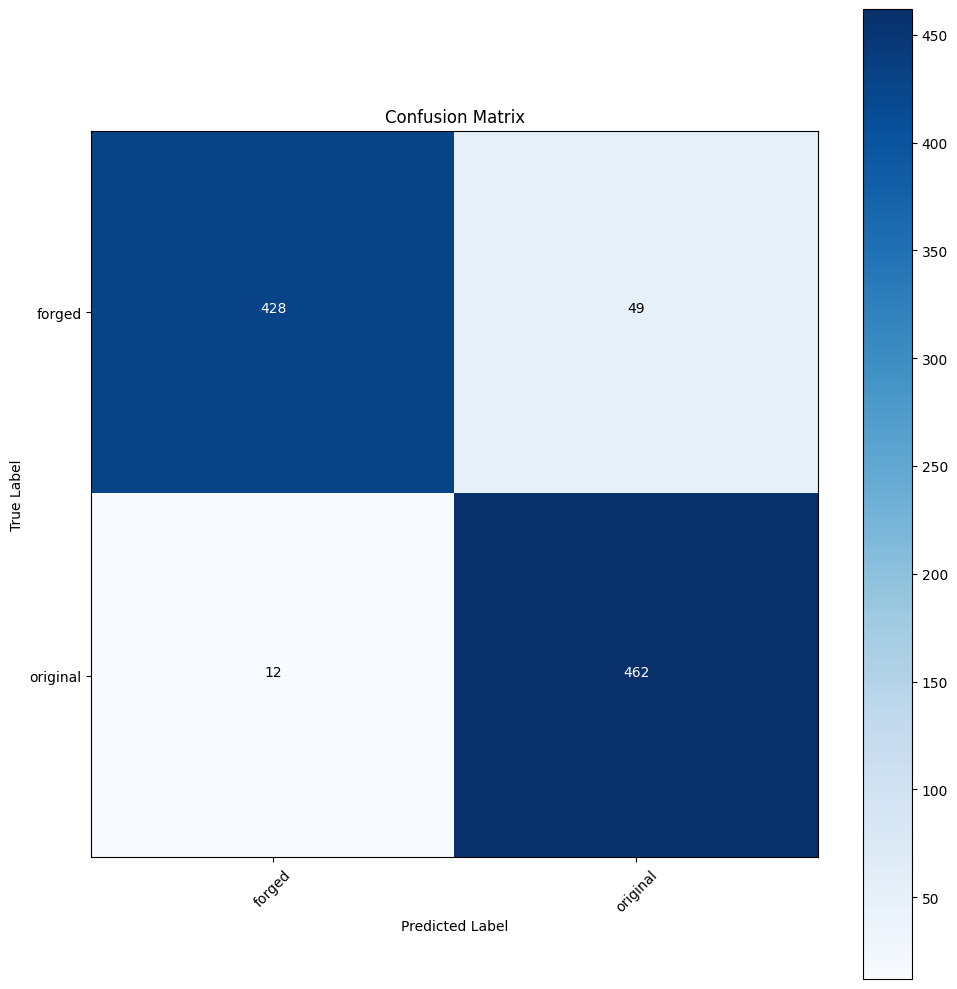

In [20]:
#Confusion Matrix dan Classification Report
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_cfx(cm, target_names, title='Confusion Matrix')
plt.savefig(f"../program/confusion_matrix.jpg")

In [21]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      forged       0.97      0.90      0.93       477
    original       0.90      0.97      0.94       474

    accuracy                           0.94       951
   macro avg       0.94      0.94      0.94       951
weighted avg       0.94      0.94      0.94       951



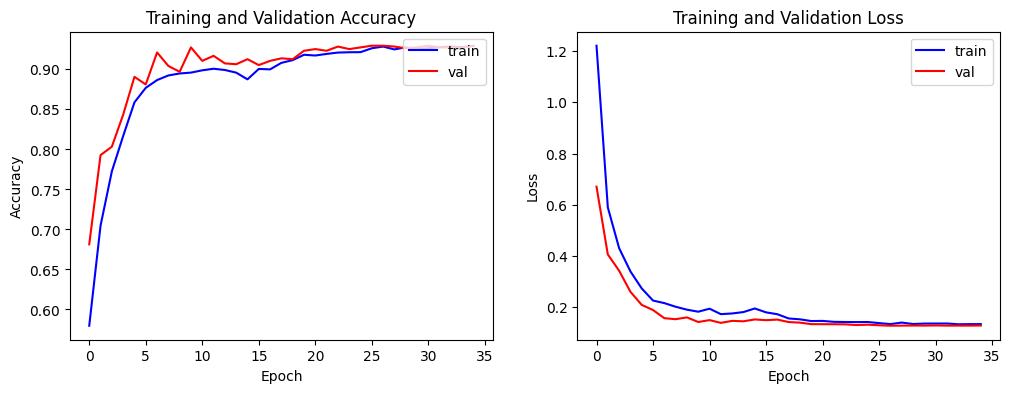

In [22]:
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
train_loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(train_accuracy))
plt.figure(figsize=(12,4))

#plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracy,'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'], loc='upper right')

#plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'b', label='Training Loss')
plt.plot(epochs,val_loss,'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')

plt.show()

In [23]:
test_label = test.classes
predict_label = y_pred

result_txt = open(f"../program/result.txt", "w")
result_txt.write(f"Accuracy: {accuracy_score(test_label, predict_label)}\nF1 score - micro: {f1_score(test_label, predict_label, average='micro')}\nF1 score - macro: {f1_score(test_label, predict_label, average='macro')}\nF1 score - weighted: {f1_score(test_label, predict_label, average='weighted')}\nClassification Report:\n{classification_report(test_label, predict_label, digits=3)}")
result_txt.close()